In [2]:
from mpi4py import MPI
import numpy as np
import dxchange
import torch as tc
import os
import torch as tc
import torch.nn.functional as F
from tqdm import tqdm
import csv
import h5py

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


In [3]:
######################################################################
# XRF and XRT data path #
data_path = './data/Xtal1_align1_adjusted1_ds1'
f_XRF_data = 'xtal1_xrf-roi-plus'
# f_XRF_data = 'xtal1_xrf-roi'
# f_XRF_data = 'xtal1_xrf-fits'
f_XRT_data = 'xtal1_scalers'

y1_true_handle = h5py.File(os.path.join(data_path, f_XRF_data), 'r')
y2_true_handle = h5py.File(os.path.join(data_path, f_XRT_data), 'r') 

element_lines_roi_idx = np.array([0, 1, 11, 14])
photon_counts_us_ic_dataset_idx = 1
photon_counts_ds_ic_dataset_idx = 2
photon_counts_abs_ic_dataset_idx = 3
# path of storing the intersecting information and the reconstructing results #
recon_path_selfAb = 'data/Xtal1_align1_adjusted1_ds1_recon/roi_plus'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'

dev = 'cpu'
# experiemtal parameters #
theta_ls = tc.from_numpy(y1_true_handle['exchange/theta'][...] * np.pi / 180).float().to(dev)
n_theta = len(theta_ls)
sample_size_n = 176
sample_height_n = 80
sample_size_cm = 0.007
this_aN_dic = {"Al": 13, "Si": 14, "Fe": 26, "Cu": 29}
n_elements = 4
probe_energy = np.array([10.0])
det_size_cm = 2.4
det_from_sample_cm = 3.0
det_ds_spacing_cm = 2.4/2
######################################################################


XRF_data = np.reshape(y1_true_handle['exchange/data'][element_lines_roi_idx], (len(element_lines_roi_idx), n_theta, sample_height_n * sample_size_n))
XRT_data = np.reshape(y2_true_handle['exchange/data'][photon_counts_abs_ic_dataset_idx], (n_theta, sample_height_n * sample_size_n))

y1_true_handle.close()
y2_true_handle.close()

## XRF projection

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


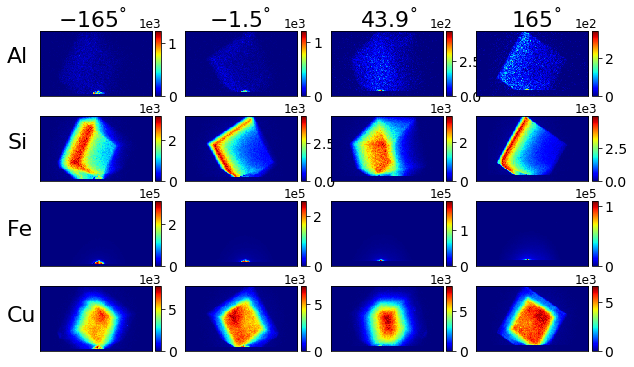

In [4]:
theta_idx_ls = np.array([0, 54, 69, 109])
XRF_data_projection =  np.reshape(XRF_data, (len(element_lines_roi_idx), n_theta, sample_height_n, sample_size_n))


fig6 = plt.figure(figsize=(10, 6))
gs6 = gridspec.GridSpec(len(element_lines_roi_idx), ncols=len(theta_idx_ls))

fig6.text(0.08, 0.8, 'Al', color='black', fontsize=22)
fig6.text(0.08, 0.6, 'Si', color='black', fontsize=22)
fig6.text(0.08, 0.4, 'Fe', color='black', fontsize=22)
fig6.text(0.08, 0.2, 'Cu', color='black', fontsize=22)

fig6.text(0.15, 0.88, r'$-165^\degree$', color='black', fontsize=22)
fig6.text(0.36, 0.88, r'$-1.5^\degree$', color='black', fontsize=22)
fig6.text(0.57, 0.88, r'$43.9^\degree$', color='black', fontsize=22)
fig6.text(0.78, 0.88, r'$165^\degree$', color='black', fontsize=22)

for idx, theta_idx in enumerate(theta_idx_ls):
    for line_idx in range(len(element_lines_roi_idx)):              
        fig6_ax1 = fig6.add_subplot(gs6[line_idx, idx])                                        
        pos = fig6_ax1.imshow(XRF_data_projection[line_idx, theta_idx], cmap='jet', vmin=0, vmax = np.max(XRF_data_projection[line_idx, theta_idx]), extent=[0, n_theta, 64, 0], origin='upper')
        plt.setp(fig6_ax1.get_xticklabels(), visible=False)
        plt.setp(fig6_ax1.get_yticklabels(), visible=False)
        fig6_ax1.tick_params(axis='both', which='both', length=0)                        
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)                        
        cbar = fig6.colorbar(pos, cax=cax) 
        cbar.ax.tick_params(labelsize=14) 
        cbar.formatter.set_powerlimits((0, 0))                        
                        

## XRF Sinogram

In [5]:
layer_idx_ls = np.arange(0,80,8)

(4, 110, 14080)


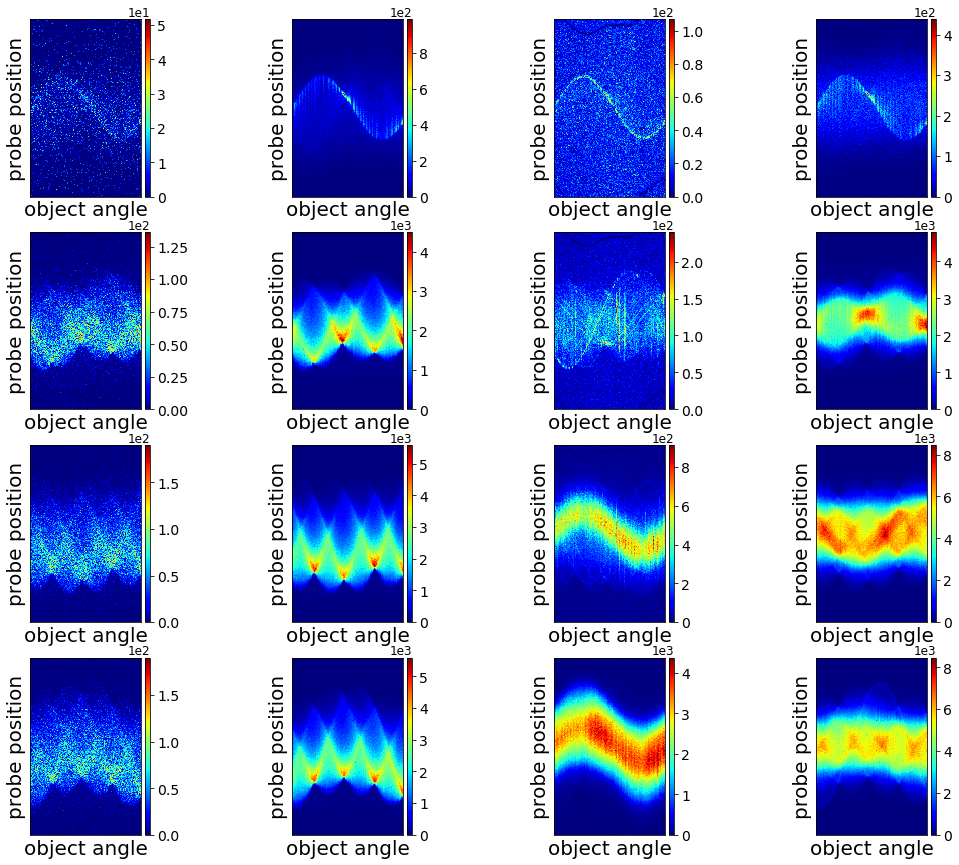

In [30]:
n_elements = len(this_aN_dic)
line_idx_all_elements_ls = [[0], [1], [2], [3]]
n_theta_cpu =  n_theta
n_theta_ds_factor = 1

print(XRF_data.shape) # (n_theta, n_lines, n_probe_pos)

fig6 = plt.figure(figsize=(18, 15))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=n_elements)
# fig6.text(0.270, 0.89, 'Ca', color='black', fontsize=24)
# fig6.text(0.700, 0.89, 'Sc', color='black', fontsize=24)
for i_element in range(n_elements):
    max_XRF_data_this_line = 0.
    for idx, layer_idx in enumerate(layer_idx_ls):
        probe_pos_st = sample_size_n * layer_idx
        probe_pos_end = sample_size_n * (layer_idx + 1)
        XRF_data_ds = np.zeros(XRF_data[0, ::n_theta_ds_factor, probe_pos_st:probe_pos_end].shape)
        line_idx_ls = line_idx_all_elements_ls[i_element]
        for line_idx in line_idx_ls:
            XRF_data_ds += XRF_data[line_idx, ::n_theta_ds_factor, probe_pos_st:probe_pos_end]
        XRF_data_ds = np.transpose(XRF_data_ds, (1,0))
        max_XRF_data_this_line = np.max(np.array([max_XRF_data_this_line, np.max(XRF_data_ds)]))
        fig6_ax1 = fig6.add_subplot(gs6[idx, i_element])
        pos = fig6_ax1.imshow(XRF_data_ds, cmap='jet', vmin=0, vmax= max_XRF_data_this_line, extent=[0, XRF_data_ds.shape[1], probe_pos_end-probe_pos_st, 0], origin='lower')
        plt.setp(fig6_ax1.get_xticklabels(), visible=False)
        plt.setp(fig6_ax1.get_yticklabels(), visible=False)
        fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
#         ticks = np.arange(0, 12000, 2000)
#         cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar = fig6.colorbar(pos, cax=cax) 
        cbar.ax.tick_params(labelsize=14) 
        cbar.formatter.set_powerlimits((0, 0))
        fig6_ax1.set_ylabel("probe position", fontsize=20)
        fig6_ax1.set_xlabel("object angle", fontsize=20)
    # cbar.ax.set_title('XRF signal', size='14')
plt.savefig('XRF_sinogram.pdf', format='pdf', dpi=600)



## XRT projection

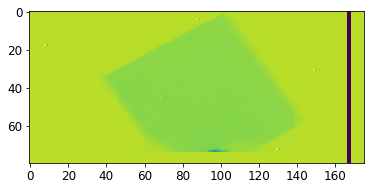

In [7]:
theta_idx = 50
XRT_data = np.reshape(XRT_data, (n_theta, sample_height_n, sample_size_n))

plt.imshow(XRT_data[theta_idx])

## XRT Sinogram

In [19]:
layer_idx_ls = np.array([32])

(110, 14080)
230137.27


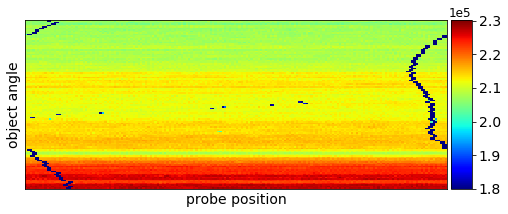

In [21]:
XRT_data = np.reshape(XRT_data, (n_theta, sample_height_n * sample_size_n))
n_elements = len(this_aN_dic)
n_theta_cpu =  n_theta
n_theta_ds_factor = 1

print(XRT_data.shape)
print(np.max(XRT_data))

# fig6 = plt.figure(figsize=(20, 30))
fig6 = plt.figure(figsize=(8, 5))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
#     print(np.max(XRT_data_ds))
    fig6_ax1 = fig6.add_subplot(gs6[idx])
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=180000, vmax= np.max(XRT_data), extent=[0, 110, 44, 0], origin='upper')
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.87, vmax= 0.94, origin='upper')
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([180000, 200000])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=14) 
    fig6_ax1.set_xlabel("probe position", fontsize=14)
    fig6_ax1.set_ylabel("object angle", fontsize=14)
# cbar.ax.set_title('XRF signal', size='14')
plt.savefig('XRT_sinogram.pdf', format='pdf', dpi=600)

(110, 14080)
200570.16


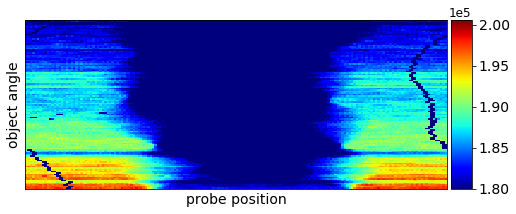

In [23]:
XRT_data = np.reshape(XRT_data, (n_theta, sample_height_n * sample_size_n))
n_elements = len(this_aN_dic)
n_theta_cpu =  n_theta
n_theta_ds_factor = 1

print(XRT_data.shape)
print(np.max(XRT_data))

# fig6 = plt.figure(figsize=(20, 30))
fig6 = plt.figure(figsize=(8, 5))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
#     print(np.max(XRT_data_ds))
    fig6_ax1 = fig6.add_subplot(gs6[idx])
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=180000, vmax= np.max(XRT_data), extent=[0, 110, 44, 0], origin='upper')
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.87, vmax= 0.94, origin='upper')
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([180000, 200000])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=14) 
    fig6_ax1.set_xlabel("probe position", fontsize=14)
    fig6_ax1.set_ylabel("object angle", fontsize=14)
# cbar.ax.set_title('XRF signal', size='14')
plt.savefig('XRT_sinogram.pdf', format='pdf', dpi=600)

(110, 14080)
1.0


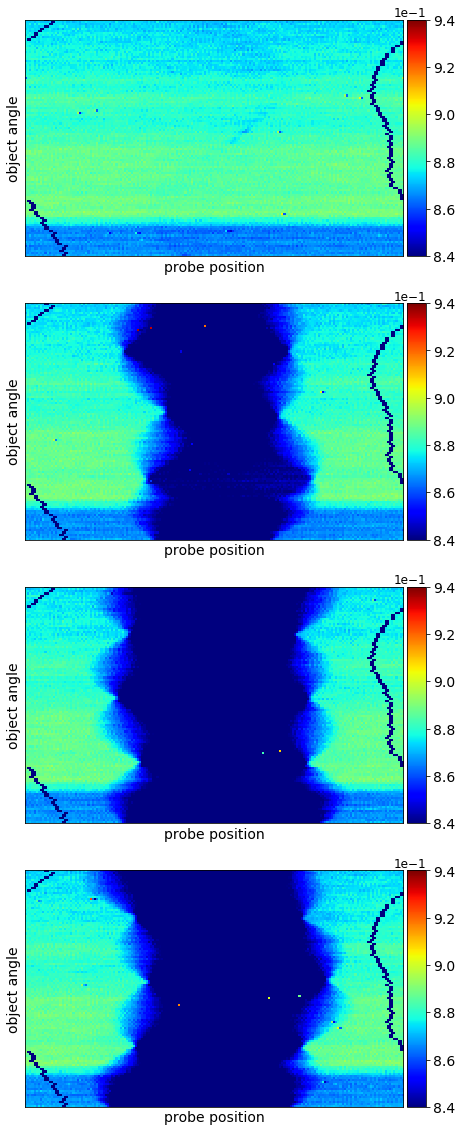

In [9]:
layer_idx_ls = np.arange(0, 80, 20)
XRT_data = np.reshape(XRT_data, (n_theta, sample_height_n * sample_size_n))
n_elements = len(this_aN_dic)
n_theta_cpu =  n_theta
n_theta_ds_factor = 1


# fig6 = plt.figure(figsize=(20, 30))
fig6 = plt.figure(figsize=(8, 20))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
#     print(np.max(XRT_data_ds))
    fig6_ax1 = fig6.add_subplot(gs6[idx])
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=180000, vmax= np.max(XRT_data), extent=[0, 110, 44, 0], origin='upper')
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.84, vmax= 0.94, origin='upper')
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([180000, 200000])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=14) 
    fig6_ax1.set_xlabel("probe position", fontsize=14)
    fig6_ax1.set_ylabel("object angle", fontsize=14)
# cbar.ax.set_title('XRF signal', size='14')
plt.savefig('XRT_sinogram.pdf', format='pdf', dpi=600)